In [59]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

# Cellular Automata S.I.R. Model

### Description

Based on the reference [paper](https://www.math.uh.edu/~zpkilpat/teaching/math4309/project/physa99_fuentes.pdf), the aim of the project is to simulate and then study the evolution of Susceptible-Infected-Removed populations over space and time.

### Assignments
1. Consider a grid of a given form (squared or exagonal or whatever) and then let propagate the SIR model. 
2. Repeat point 1 several times in order to obtain several reference datasets
3. Try to predict the evolution of the epidemic both in space and time on the basis of the previous steps, e.g. by means of 
4. Define a metric on how the epidemic evolved e.g. assigning a probability for a given node not to get infected or predict the fraction of the nodes that got infected at the end of the epidemic

### Contacts
* Leonardo Badia <badia@dei.unipd.it>

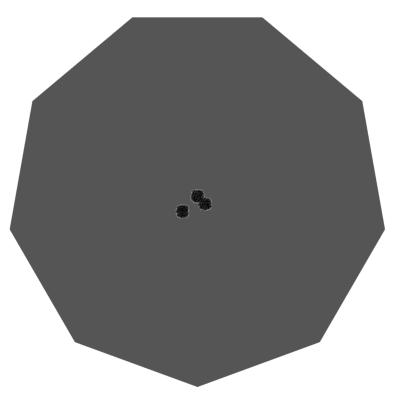

In [70]:
def draw_line(mat, point1, point2):
    x0, y0 = point1[0], point1[1];
    x1, y1 = point2[0], point2[1];
    if not (0 <= x0 < mat.shape[0] and 0 <= x1 < mat.shape[0] and
            0 <= y0 < mat.shape[1] and 0 <= y1 < mat.shape[1]):
        raise ValueError('Invalid coordinates.')
        
    if (x0, y0) == (x1, y1):
        mat[x0, y0] = 0
        return mat
    
    # Swap axes if Y slope is smaller than X slope
    transpose = abs(x1 - x0) < abs(y1 - y0)
    if transpose:
        mat = mat.T
        x0, y0, x1, y1 = y0, x0, y1, x1
        
    # Swap line direction to go left-to-right if necessary
    if x0 > x1:
        x0, y0, x1, y1 = x1, y1, x0, y0
        
    # Compute intermediate coordinates using line equation
    x = np.arange(x0 + 1, x1)
    y = np.round(((y1 - y0) / (x1 - x0)) * (x - x0) + y0).astype(x.dtype)
    
    # Write intermediate coordinates
    mat[x, y] = 0

    return mat if not transpose else mat.T

    
def new_population(N, vertices):
    from numpy import pi, floor, ceil, cos, sin;
    
    if vertices < 3:
        raise Exception('The number of vertices must be greater than 2.');
        
    n = vertices;
    
    if N%2 ==0: N+=1;
    M = np.ones((N,N), dtype=int)+1

    center = [floor(N/2), floor(N/2)];
    radius = floor(N/2);
    angle = 2*pi/n;
    
    vertices=np.zeros((n+1,2), dtype=int);
    for vertex in range(n):
        x = int(floor(center[0] + radius*cos(vertex*angle)));
        y = int(floor(center[1] - radius*sin(vertex*angle)));
        M[x,y] = 0;
        vertices[vertex]=[x,y];
    vertices[n]=vertices[0];

    for i in range(1,len(vertices)):
        M = draw_line(M, vertices[i-1], vertices[i]);
            
       
    for row in range(N):
        row_i = M[row,:]
        
        x1 = np.argwhere(M[row,:]==0)
        x2 = np.argwhere(M[row,:]==0)
        if len(x1)==0 or len(x2)==0: continue;
        x1 = min(x1); x2 = max(x2);
        if x1==0 and x2==0: continue;
        M = draw_line(M, [row, x1], [row, x2]);
          
    return M;

def change_status(indexes):
    global population;

    if type(indexes)==tuple:
        indexes=[indexes]
        
    for index in indexes:
        status = population[index];   
        if status!=0 and status!=1 and status!=-1:
            raise Exception('status must be a number equal to -1, 0 or 1.');        
        if status==0:
            population[index] = 1;
        elif status==1:
            population[index] = -1;
        else:
            population = population; # useless but for clarity 

def neighbors(points):
    global population
    neighbors_list = []
    if type(points)==tuple:
        points=[points]
    for point in points:
        x0, y0 = point[0], point[1]
        if not (0 <= x0 < population.shape[0] and 0 <= y0 < population.shape[1]):
            raise ValueError('Invalid coordinates.')

        mx = (x0 != population.shape[0]-1)+1
        my = (y0 != population.shape[1]-1)+1


        for i in range(-1,mx):
            for j in range (-1,my):
                if population[x0+i,y0+j]!=2 and not (i==0 and j==0):
                    neighbors_list.append((x0+i, y0+j))
    return neighbors_list

def propagate(neighbors):
    global population
    p_i = 0.5 # probability of infection
    p_r = 0.1 # probability of recovery
    for neighbor in neighbors:
        infection = np.random.choice([1, 0], p=[p_i, 1-p_i])
        recovery = np.random.choice([1, 0], p=[p_r, 1-p_r])
        if population[neighbor]==0 and infection:
            change_status(neighbor)
        elif population[neighbor]==1 and recovery:
            change_status(neighbor)
            
def infected_list():
    global population
    return np.argwhere(population==1)

resolution, polygon_sides = 1275, 9
population = new_population(resolution, polygon_sides);

center = int(np.floor(resolution/2))




plt.figure(figsize = (7,7));
plt.axis('off');

# 0 = S , 1 = I , -1 = R
infected = [(center,center), (center+50,center-50), (center+25,center+25)]
change_status(infected)
for cycle in range(23):    
    neighbors_list = neighbors(infected)
    propagate(neighbors_list)
    infected = infected_list()
    plt.imshow(population, cmap='gray', vmin=-1, vmax=2);
    #time.sleep(0.1)
